# Multiclass Text Classification with Feed-forward Neural Networks and Word Embeddings

First, we will do some initialization.

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


### Load the Dataset and pre-processing

We will be using the AG's News Topic Classification Dataset. AG is a collection of news articles categorized into four different topics: *1-World, 2-Sports, 3-Business, 4-Sci/Tech* 
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict. The files `train.csv` and ``test.csv` contain all the samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description


In [2]:
train_df = pd.read_csv('train.csv', header=None)
train_df.columns = ['class index', 'title', 'description']
train_df

,class index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The class labels are distributed in a separated file `classes.txt`. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [3]:
labels = open('classes.txt').read().splitlines()
classes = train_df['class index'].map(lambda i: labels[i-1])
train_df.insert(1, 'class', classes)
train_df

,class index,class,title,description
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


However, the text contains some spurious backslashes in some parts of the text. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
An example can be seen below, between the words "dwindling" and "band".

In [4]:
print(train_df.loc[0, 'description'])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method and we will join the title and description in a new column `text`

In [5]:
train_df['text'] = train_df['title'].str.lower() + " " + train_df['description'].str.lower()
train_df['text'] = train_df['text'].str.replace('\\', ' ', regex=False)
train_df

,class index,class,title,description,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [12]:
from nltk.tokenize import word_tokenize

train_df['tokens'] = train_df['text'].progress_map(word_tokenize)
train_df

  0%|          | 0/96000 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens
0,9116,1,World,Najaf's Residents Feel Trapped in Battle (AP),"AP - For nearly three weeks, Amer al-Jamali ha...",najaf's residents feel trapped in battle (ap) ...,"[najaf, 's, residents, feel, trapped, in, batt..."
1,99831,3,Business,U.S. FDA Adds Restrictions to Acne Drug,WASHINGTON (Reuters) - Roche's acne drug Accu...,u.s. fda adds restrictions to acne drug washi...,"[u.s., fda, adds, restrictions, to, acne, drug..."
2,10663,3,Business,Smithfield Foods Profit More Than Doubles,"Smithfield Foods Inc. (SFD.N: Quote, Profile, ...",smithfield foods profit more than doubles smit...,"[smithfield, foods, profit, more, than, double..."
3,73175,4,Sci/Tech,PluggedIn: The OQO Is Not Just Another Handhel...,SAN FRANCISCO (Reuters) - A full-fledged Wind...,pluggedin: the oqo is not just another handhel...,"[pluggedin, :, the, oqo, is, not, just, anothe..."
4,104494,4,Sci/Tech,IBM invigorates LTO tape storage,LTO (linear tape open)-based drives are invigo...,ibm invigorates lto tape storage lto (linear t...,"[ibm, invigorates, lto, tape, storage, lto, (,..."
...,...,...,...,...,...,...,...
95995,89460,1,World,"Bush, Blair See Hope for Palestinian State (AP)","AP - As Yasser Arafat was buried, President Bu...","bush, blair see hope for palestinian state (ap...","[bush, ,, blair, see, hope, for, palestinian, ..."
95996,60620,1,World,Ex-Soldiers Vow to Bring Order to Haiti Capital,Ex-soldiers who helped topple former President...,ex-soldiers vow to bring order to haiti capita...,"[ex-soldiers, vow, to, bring, order, to, haiti..."
95997,34086,1,World,Musharraf says U.S. must address root of terro...,Reuters - The United States could lose its war...,musharraf says u.s. must address root of terro...,"[musharraf, says, u.s., must, address, root, o..."
95998,58067,1,World,Nuclear materials #39;vanish #39; in Iraq,Equipment and materials that could be used to ...,nuclear materials #39;vanish #39; in iraq equ...,"[nuclear, materials, #, 39, ;, vanish, #, 39, ..."


### Word embedding

Now we will load the GloVe word embeddings.

Please download the these GloVe embeddings from the [Stanford GloVe](https://nlp.stanford.edu/projects/glove/) website. Once the `glove.6B.zip` file is downloaded, uncompress it and place the extracted `glove.6B.300d.txt` file in the folder of the notebook.

In [7]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", no_header=True)

We will need a way to handle unknown tokens in the vocabulary. Our approach will be to add a new embedding to GloVe that will be used to represent them. This new embedding will be initialized as the average of all the GloVe embeddings.

We will also add another embedding, this one initialized to zeros, that will be used to pad the sequences of tokens so that they all have the same length. This will be useful when we train with mini-batches.

In [ ]:
# ADD YOUR CODE HERE



(400000, 400001)

### Definition of the model

Next, we construct our PyTorch model, which is a feed-forward neural network with two layers and an embedding layer. 

An embedding layer is  simple lookup table that stores embeddings of a fixed dictionary and size. It is used to convert tokens ids into their embedded representation. It can be initialized with the pre-trained glove vectors.


In [ ]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vectors, pad_id, hidden_dim, output_dim, dropout):
        super().__init__()
        # embeddings must be a tensor
        if not torch.is_tensor(vectors):
            vectors = torch.tensor(vectors)
        # keep padding id
        self.padding_idx = pad_id
        # Embedding layer
        self.embs = nn.Embedding.from_pretrained(vectors, padding_idx=pad_id)
        # Feedforward layers
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(vectors.shape[1], hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        
        x = self.embs(x)
        # The embeddings of all the tokens in the sequence must be aggregated into a single embedding vector, which will be passed to the rest of the model. 
        # We will use the mean of the token embeddings as the aggregated embedding vector (excluding padding)
        # ADD YOUR CODE HERE


        
        output = self.layers(x)
        
        return output

### Prepare the dataset for training

We divide the training set into a train and validation sets

In [13]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(train_df, train_size=0.8)
train_df.reset_index(inplace=True)
dev_df.reset_index(inplace=True)

As input to the neural network we need fixed length sequences of tokens ids (not token strings). We need to convert all tokens in the dataframe to their corresponding id in the glove embedding. We will also pad all sequences to a fixed length.

We will add a new column to our dataframe that will contain the padded sequences of token ids. All sentences will be padded to the maximum sequence length 

In [ ]:
# find the length of the longest list of tokens
max_tokens = train_df['tokens'].map(len).max()


# function that gets a list of tokens and returns a list of token ids,
# with padding added accordingly
def token_ids(tokens):
    ## ADD YOUR CODE HERE
    

    

# add new column to the dataframe
train_df['token ids'] = train_df['tokens'].progress_map(token_ids, max_tokens)
train_df

  0%|          | 0/76800 [00:00<?, ?it/s]

,level_0,index,class index,class,title,description,text,tokens,token ids
0,8014,23101,4,Sci/Tech,German teenager indicted over Sasser worm,Eighteen-year-old Sven Jaschan was indicted ye...,german teenager indicted over sasser worm eigh...,"[german, teenager, indicted, over, sasser, wor...","[514, 7186, 5687, 74, 44507, 16528, 129215, 16..."
1,81289,104829,3,Business,Government claims collusion for the first time,Investigators looking into price manipulation ...,government claims collusion for the first time...,"[government, claims, collusion, for, the, firs...","[78, 1267, 23678, 10, 0, 58, 79, 2255, 862, 75..."
2,63791,101196,4,Sci/Tech,US ; CIA funds chatroom surveillance,"US News, A university in New York has been fun...","us ; cia funds chatroom surveillance us news, ...","[us, ;, cia, funds, chatroom, surveillance, us...","[95, 89, 3306, 1104, 114150, 4895, 95, 172, 1,..."
3,92730,59896,1,World,AP: Report Finds Lavish Spending at TSA,WASHINGTON - The government agency in charge o...,ap: report finds lavish spending at tsa washin...,"[ap, :, report, finds, lavish, spending, at, t...","[1582, 45, 255, 3380, 12350, 1109, 22, 23252, ..."
4,93510,71589,3,Business,Reynolds American Reports First Earnings Since...,CHARLOTTE -- Reynolds American reports a third...,reynolds american reports first earnings since...,"[reynolds, american, reports, first, earnings,...","[7204, 140, 687, 58, 1462, 108, 3176, 17, 1556..."
...,...,...,...,...,...,...,...,...,...
76795,24552,19152,3,Business,Rio Says It May Sell 51 Stake in Brazilian Gol...,"Rio Tinto Group, the world #39;s third- larges...",rio says it may sell 51 stake in brazilian gol...,"[rio, says, it, may, sell, 51, stake, in, braz...","[3955, 210, 20, 107, 1243, 3840, 2388, 6, 2688..."
76796,50368,25920,4,Sci/Tech,Lens does away with blurry snaps,\A specially shaped camera lens which means im...,lens does away with blurry snaps a specially ...,"[lens, does, away, with, blurry, snaps, a, spe...","[9024, 260, 420, 17, 41438, 23917, 7, 9823, 60..."
76797,15200,88278,1,World,Make Arafats dream a reality - Annan,UN Secretary-General Kofi Annan today urged Pa...,make arafats dream a reality - annan un secret...,"[make, arafats, dream, a, reality, -, annan, u...","[159, 333365, 2895, 7, 2532, 11, 3440, 750, 24..."
76798,13418,71761,1,World,Tons of Explosives Missing from Former Iraq At...,VIENNA (Reuters) - Nearly 380 tons of explosi...,tons of explosives missing from former iraq at...,"[tons, of, explosives, missing, from, former, ...","[2474, 3, 4141, 1510, 25, 157, 233, 4065, 576,..."


We do the same for the validation set

In [15]:
max_tokens = dev_df['tokens'].map(len).max()
dev_df['token ids'] = dev_df['tokens'].progress_map(token_ids)
dev_df

  0%|          | 0/19200 [00:00<?, ?it/s]

,level_0,index,class index,class,title,description,text,tokens,token ids
0,82624,105584,3,Business,Holiday Shopping Gets Off to Slow Start,NEW YORK (Reuters) - The U.S. holiday shoppin...,holiday shopping gets off to slow start new y...,"[holiday, shopping, gets, off, to, slow, start...","[2332, 3013, 1666, 138, 4, 2049, 465, 50, 196,..."
1,74269,116598,2,Sports,Pedro agrees to join the Mets,Speaking to a Dominican Republic television st...,pedro agrees to join the mets speaking to a do...,"[pedro, agrees, to, join, the, mets, speaking,...","[6219, 6143, 4, 1429, 0, 4812, 1354, 4, 7, 624..."
2,95593,97807,2,Sports,WHAT THE PAPERS SAY,NEWS OF THE WORLD: Ashley Cole last night call...,what the papers say news of the world: ashley ...,"[what, the, papers, say, news, of, the, world,...","[102, 0, 3270, 203, 172, 3, 0, 85, 45, 9358, 6..."
3,80835,9726,4,Sci/Tech,Second Career for Old Robot: Art,A German art group reprograms old assembly-lin...,second career for old robot: art a german art ...,"[second, career, for, old, robot, :, art, a, g...","[126, 432, 10, 167, 9247, 45, 760, 7, 514, 760..."
4,59027,35095,2,Sports,Bonds to remain with Giants through 2006,"San Francisco, CA (Sports Network) - The San F...",bonds to remain with giants through 2006 san f...,"[bonds, to, remain, with, giants, through, 200...","[1947, 4, 944, 17, 2897, 131, 585, 614, 1518, ..."
...,...,...,...,...,...,...,...,...,...
19195,5978,63995,2,Sports,Hantuchova wins; Pierce loses in Zurich,"Zurich, Switzerland (Sports Network) - Slovaki...",hantuchova wins; pierce loses in zurich zurich...,"[hantuchova, wins, ;, pierce, loses, in, zuric...","[23534, 1890, 89, 7054, 7233, 6, 8548, 8548, 1..."
19196,3811,111324,3,Business,Crude Oil Rises as OPEC Ministers Call for a P...,Crude oil rose for a second day on speculation...,crude oil rises as opec ministers call for a p...,"[crude, oil, rises, as, opec, ministers, call,...","[2241, 316, 4890, 19, 4684, 1401, 580, 10, 7, ..."
19197,61692,68655,3,Business,Schlumberger 3Q Profit Misses Expectations,Oilfield and information services firm Schlumb...,schlumberger 3q profit misses expectations oil...,"[schlumberger, 3q, profit, misses, expectation...","[43625, 47935, 1269, 13392, 2435, 28675, 5, 41..."
19198,17758,97915,2,Sports,NBA Melee Another Black Eye for Detroit (AP),AP - The sight of Detroit fans scuffling with ...,nba melee another black eye for detroit (ap) a...,"[nba, melee, another, black, eye, for, detroit...","[2809, 21909, 170, 521, 2090, 10, 2369, 23, 15..."


Create the dataset for training

In [16]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x[index])
        y = torch.tensor(self.y[index])
        return x, y

### Training

Next, we implement the training procedure. We compute the loss and accuracy on the development partition after each epoch.

In [ ]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# hyperparameters
lr = 1e-3
weight_decay = 0
batch_size = 500
shuffle = True
n_epochs = 5
hidden_dim = 50
output_dim = len(labels)
dropout = 0.1
vectors = glove.vectors

# initialize the model, loss function, optimizer, and data-loader
model = Model(vectors, pad_id, hidden_dim, output_dim, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_ds = MyDataset(train_df['token ids'], train_df['class index'] - 1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
dev_ds = MyDataset(dev_df['token ids'], dev_df['class index'] - 1)
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=shuffle)

train_loss = []
train_acc = []

dev_loss = []
dev_acc = []

# train the model
for epoch in range(n_epochs):
    losses = []
    gold = []
    pred = []
    model.train()
    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        # clear gradients
        model.zero_grad()
        # send batch to right device
        X = X.to(device)
        y_true = y_true.to(device)
        # predict label scores
        y_pred = model(X)
        # compute loss
        loss = loss_func(y_pred, y_true)
        # accumulate for plotting
        losses.append(loss.detach().cpu().item())
        gold.append(y_true.detach().cpu().numpy())
        pred.append(np.argmax(y_pred.detach().cpu().numpy(), axis=1))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    train_loss.append(np.mean(losses))
    train_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))
    
    model.eval()
    with torch.no_grad():
        losses = []
        gold = []
        pred = []
        for X, y_true in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            X = X.to(device)
            y_true = y_true.to(device)
            y_pred = model(X)
            loss = loss_func(y_pred, y_true)
            losses.append(loss.cpu().item())
            gold.append(y_true.cpu().numpy())
            pred.append(np.argmax(y_pred.cpu().numpy(), axis=1))
        dev_loss.append(np.mean(losses))
        dev_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))

epoch 1 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/154 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/39 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/154 [00:00<?, ?it/s]

Let's plot the loss and accuracy on dev:

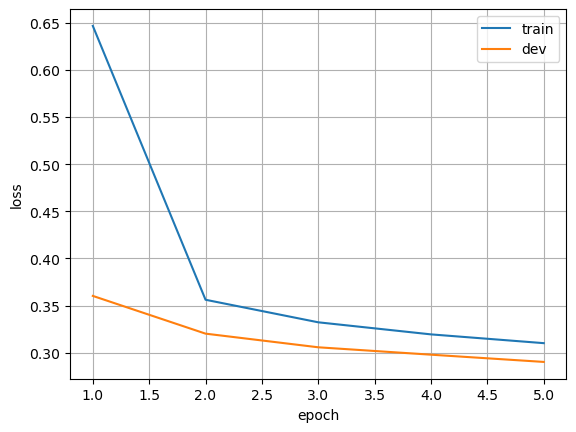

In [18]:
import matplotlib.pyplot as plt


x = np.arange(n_epochs) + 1

plt.plot(x, train_loss)
plt.plot(x, dev_loss)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

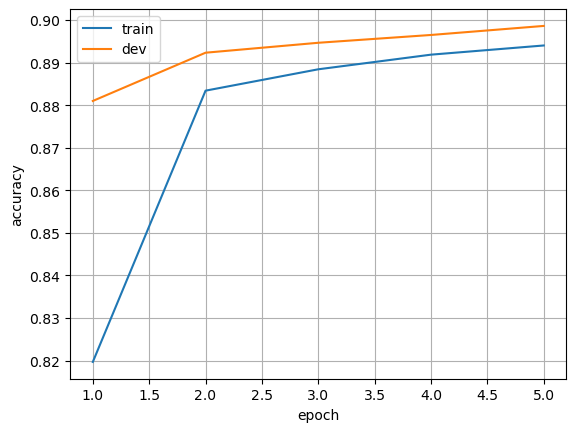

In [19]:
plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

Next, we evaluate on the testing partition:

In [21]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('test.csv', header=None)
test_df.columns = ['class index', 'title', 'description']
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower()
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False)
test_df['tokens'] = test_df['text'].progress_map(word_tokenize)
max_tokens = test_df['tokens'].map(len).max()
test_df['token ids'] = test_df['tokens'].progress_map(token_ids)

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [22]:
from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

dataset = MyDataset(test_df['token ids'], test_df['class index'] - 1)
data_loader = DataLoader(dataset, batch_size=batch_size)
y_pred = []

# don't store gradients
with torch.no_grad():
    for X, _ in tqdm(data_loader):
        X = X.to(device)
        # predict one class per example
        y = torch.argmax(model(X), dim=1)
        # convert tensor to numpy array (sending it back to the cpu if needed)
        y_pred.append(y.cpu().numpy())
        # print results
    print(classification_report(dataset.y, np.concatenate(y_pred), target_names=labels))

  0%|          | 0/16 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       World       0.93      0.87      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.85      0.85      0.85      1900
    Sci/Tech       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

